In [1]:
!pip -q install transformers torch pandas matplotlib tqdm


In [2]:
import math
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM


In [4]:
df = pd.read_csv("data/macss_abstracts.csv") 
df.head()


,paper_id,title,abstract,year
0,macss_01,News to Numbers: A Comparative Analysis of Tra...,This thesis investigates the comparative effec...,2025
1,macss_02,Labor Market Shocks and Heterogeneous Adjustme...,This study examines how labor markets adjust t...,2025
2,macss_03,The Cost of Decentralization? Welfare Comparis...,This paper quantifies the welfare implications...,2025
3,macss_04,The Art of Positivity in Drawing: Unveiling th...,This study integrates visual creative tasks wi...,2025
4,macss_05,Mapping Informality and Violence: Machine Lear...,This study examines the relationship between n...,2025


In [5]:
df["abstract"].head(3)


0    This thesis investigates the comparative effec...
1    This study examines how labor markets adjust t...
2    This paper quantifies the welfare implications...
Name: abstract, dtype: object

In [6]:
MODEL_NAME = "distilgpt2"   # fast + standard for perplexity
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# GPT-style models need this
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
@torch.no_grad()
def compute_perplexity(text, max_length=512):
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)
    n_tokens = input_ids.shape[1]

    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss.item()
    ppl = math.exp(loss) if loss < 20 else float("inf")  # avoid overflow

    return ppl, n_tokens


In [8]:
df_small = df.sample(n=min(len(df), 150), random_state=42).reset_index(drop=True)

perplexities = []
num_tokens = []

for txt in tqdm(df_small["abstract"], desc="Computing perplexity"):
    ppl, ntok = compute_perplexity(txt)
    perplexities.append(ppl)
    num_tokens.append(ntok)

df_small["perplexity"] = perplexities
df_small["num_tokens"] = num_tokens


Computing perplexity:   0%|          | 0/40 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


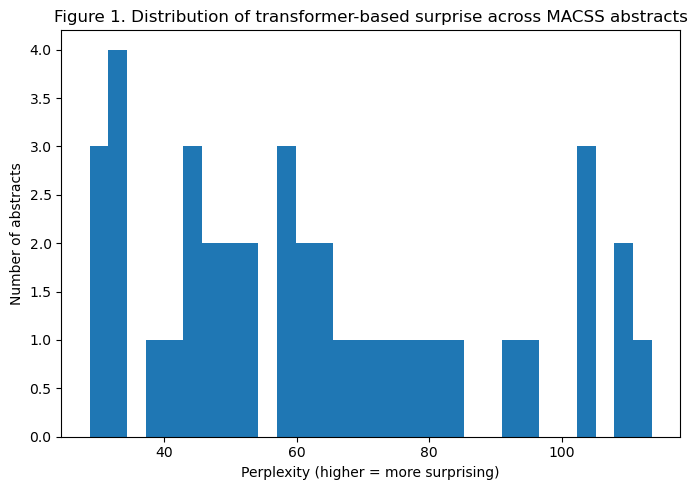

In [9]:
vals = df_small["perplexity"].replace([float("inf")], pd.NA).dropna()

plt.figure(figsize=(7,5))
plt.hist(vals, bins=30)
plt.xlabel("Perplexity (higher = more surprising)")
plt.ylabel("Number of abstracts")
plt.title("Figure 1. Distribution of transformer-based surprise across MACSS abstracts")
plt.tight_layout()
plt.show()


In [10]:
plt.figure(figsize=(7,5))
plt.hist(vals, bins=30)
plt.xlabel("Perplexity (higher = more surprising)")
plt.ylabel("Number of abstracts")
plt.title("Figure 1. Distribution of transformer-based surprise across MACSS abstracts")
plt.tight_layout()
plt.savefig("figure1_perplexity_distribution.png", dpi=300)
plt.close()
